# Задание 2 по курсу «Байесовский выбор моделей»


In [254]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
import math
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

### Задача 1

Пусь есть НОР (i.i.d.) выборка $x_1, ..., x_n$, $n > 100$ из нормального распределения со средним m и неизвестной дисперсией $\sigma$. На уровне значимости $\alpha$ проверить гипотезу $H_0$ о том, что $m = 0$. Выписать критическую область и сосчитать мощность критерия W в зависимости от истинных $m$ и $\sigma$.

### Решение:
Пусть есть статистика: $ T = \frac{1}{n} \sum\limits_{i=1}^n x_i $, в условиях истинности нулевой гипотезы получаем $T \sim Norm(0, \frac{\sigma^2}{n})$, 

но $\sigma$ нам не дана, поэтому посчитаем её через выборку $\sigma^2 = \frac{1}{n} \sum\limits_{i=1}^n(x_i - \overline{x})^2$, $m = \frac{1}{n} \sum\limits_{i=1}^n x_i$

Тогда из можем посчитать критическую область, это будет $|T(Z)| \leq t_{кр}(\alpha)$, где $t_{кр}(\alpha) = |F_{Norm(0, \frac{\sigma^2}{n})}^{-1}(\alpha/2)|$, если же $|T(Z)| > t_{кр}(\alpha)$, то гипотеза отвергается.

Если же у нас $X \sim Norm(m, \sigma^2)$, тогда мощность будет $|T(X)| > t_{кр}(\alpha)$, найдем мощность в зависимости от истинных $m$ и $\sigma$.

$$
W(m, \sigma^2) = \int\limits_{-\infty}^{-t_{кр}} \frac{1}{\sqrt{2 \pi \frac{\sigma^2}{n}}} \exp{- \frac{(t-m)^2}{2 \frac{\sigma^2}{n}}}dt
               + \int\limits_{t_{кр}}^{+\infty} \frac{1}{\sqrt{2 \pi \frac{\sigma^2}{n}}} \exp{- \frac{(t-m)^2}{2 \frac{\sigma^2}{n}}}dt
$$
Или же:
$$
W(m, sigma^2) = 1 + F_{Norm(m, \sigma^2)}(-t_{кр}) - F_{Norm(m, \sigma^2)}(t_{кр})
$$
Давайте построим графики:

In [211]:
def gen_xy(loc, scale, n=100):
    x = [stats.norm.rvs(loc=loc, scale=scale) for _ in range(n)]
    x.sort()
    mean = np.mean(x)
    sigma = np.std(x)
    x = np.array(x)
    y = stats.norm.pdf(x, loc=mean, scale=sigma)
    return x, y, mean, sigma

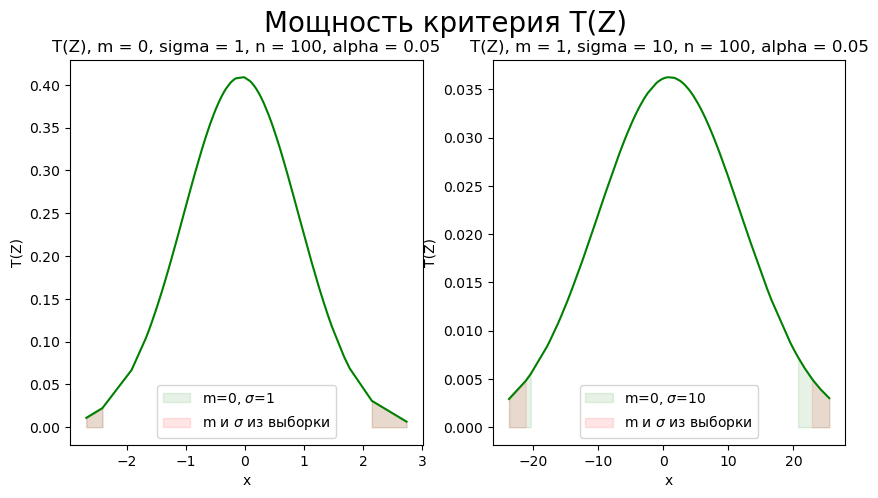

In [243]:
n, alpha = 100, 0.05

fig, ax_ = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Мощность критерия T(Z)', fontsize=20)

ax = ax_[0]
x, y, mean, sigma = gen_xy(0, 1)
ax.plot(x,y, color ='g')
ax.set_title('T(Z), m = 0, sigma = 1, n = 100, alpha = 0.05')
ax.set_ylabel('T(Z)')
ax.set_xlabel('x')

ax.fill_between(x[np.where(x<stats.norm.ppf(alpha/2, loc=0, scale=1))], 
                 y[np.where(x<stats.norm.ppf(alpha/2, loc=0, scale=1))], 
                 alpha = 0.1, color ='g')
ax.fill_between(x[np.where(x>stats.norm.isf(alpha/2, loc=0, scale=1))], 
                y[np.where(x>stats.norm.isf(alpha/2, loc=0, scale=1))], 
                 alpha = 0.1, color ='g', label=r'm=0, $\sigma$=1')
ax.fill_between(x[np.where(x<stats.norm.ppf(alpha/2, loc=mean, scale=sigma))], 
                 y[np.where(x<stats.norm.ppf(alpha/2, loc=mean, scale=sigma))], 
                 alpha = 0.1, color ='r')
ax.fill_between(x[np.where(x>stats.norm.isf(alpha/2, loc=mean, scale=sigma))], 
                 y[np.where(x>stats.norm.isf(alpha/2, loc=mean, scale=sigma))], 
                 alpha = 0.1, color ='r', label=r'm и $\sigma$ из выборки')
ax.legend()
ax = ax_[1]
x, y, mean, sigma = gen_xy(1, 10)
ax.plot(x,y, color ='g')
ax.set_title('T(Z), m = 1, sigma = 10, n = 100, alpha = 0.05')
ax.set_ylabel('T(Z)')
ax.set_xlabel('x')

ax.fill_between(x[np.where(x<stats.norm.ppf(alpha/2, loc=1, scale=10))], 
                 y[np.where(x<stats.norm.ppf(alpha/2, loc=1, scale=10))], 
                 alpha = 0.1, color ='g', label=r'm=0, $\sigma$=10')
ax.fill_between(x[np.where(x>stats.norm.isf(alpha/2, loc=1, scale=10))], 
                 y[np.where(x>stats.norm.isf(alpha/2, loc=1, scale=10))], 
                 alpha = 0.1, color ='g')

ax.fill_between(x[np.where(x<stats.norm.ppf(alpha/2, loc=mean, scale=sigma))], 
                 y[np.where(x<stats.norm.ppf(alpha/2, loc=mean, scale=sigma))], 
                 alpha = 0.1, color ='r')
ax.fill_between(x[np.where(x>stats.norm.isf(alpha/2, loc=mean, scale=sigma))], 
                 y[np.where(x>stats.norm.isf(alpha/2, loc=mean, scale=sigma))], 
                 alpha = 0.1, color ='r', label=r'm и $\sigma$ из выборки')
ax.legend()
plt.show()

### Задача 3

Пусть имеется обучающая и тестовая выборки $(X_1, y_1), X_1 \in \mathbb{R}^{m_1 \times n}, y_1 \in \{-1, 1\}^{m_1}$, $(X_2, y_2), X_2 \in \mathbb{R}^{m_2 \times n}, y_2 \in \{-1, 1\}^{m_2}$, полученные из общей модели генерации данных с совместным правдоподобием

$$
p(y, w, X|\alpha) = \prod\limits_{j} Norm(x_i | 0, \sigma^2 I_n) Norm(w|0, \alpha^{-1}I_n) \prod\limits_{j} p(y_j | x_j, w)
$$, 
где $p(y_j|x_j, w)$ предсказывается моделью логистической регрессии:
$$
\mathbb{P}(y_j = 1) = \frac{1}{1+\exp{-w^Tx_j}}
$$

1. Пусть вам известен настоящий вектор w, полученный из априорного распределения $p(w|\alpha) = Norm(w|0, \alpha^{-1}I_n)$. Вычислите ожидаемое максимальное качество в терминах AUC на тестовой выборке при $m_2 \rightarrow \infty$ сэплированием и аналитически.
2. Пусть вами случайно выбран некоторый вектор $w_0$, независимо от настоящего w. Вычислить в этом случае для разных $m_2$ ожидаемое качество в терминах AUC $\mathbb{E}(AUC)$ для разных $m_2$ сэплированием и аналитически.

### Решение: 
Из лекций Константина Вячеславовича:

$$
AUC(w) = \frac{1}{l_+ l_-}\sum\limits_{t_i \in l_+} \sum\limits_{t_j \in l_-} \mathbb{1} [g(t_i) < g(t_j)]
$$

Пусть у нас достаточно большая выборка D, например, бесконечная, тогда замением $l_+, l_-$ на вероятности.
$$
AUC(w)=\frac{\sum\limits_{i}^D \sum\limits_{j}^D \mathbb{P}(y_i = 0) \mathbb{P}(y_j=1)\cdot \mathbb{1} [g(y_i = 1) < g(t_j = 1)] }{\sum\limits_{i}^D  \sum\limits_{j}^D \mathbb{P}(y_i = 0) \mathbb{P}(y_j=1)}  = \frac{\sum\limits_{i}^D \sum\limits_{j}^D (1 - p_i) p_j \cdot \mathbb{1}\left[g_i< g_j \right]}{\sum\limits_{i}^D \sum\limits_{j}^D (1-p_i)p_j}
$$
Заметим, что каждая пара $(i, j)$ появится один раз при условии того, что $g_i < g_j$, получается что, если $(1 - p_i) p_j$ ? $(1 - p_j) p_i$ и  $f_i$ ? $f_j$, то AUC получается больше. Получили $\forall i,j$ $p_i < p_j \Rightarrow g_i < g_j$, что ранжирование вероятности и моделей одинаковое, т.е. качество больше, чем при $g_i = p_i$ $AUC$ не получить.


In [336]:
def sigmoid(x, w):
    return 1./(1+np.exp(-w@x))
def help_gener(x, w):
    return np.random.binomial(1, sigmoid(x, w))
def get_data(w, m, n, sigma):
    X = np.random.multivariate_normal(mean=np.zeros(n), cov=np.eye(n)*sigma**2, size=m)
    y = np.apply_along_axis(lambda x: help_gener(w,x), 1, X)
    return X, y

def exp_AUC(probability, m2):
    AUC, divider = 0., 0.
    for i in range(m2):
        for j in range(m2):
            divider += (1-probability[i])*probability[j]
            if probability[i] < probability[j]:
                AUC += (1-probability[i])*probability[j]
    return AUC/divider

def sample_AUC(w, neg, pos):
    AUC = []
    
    for k in range(10):
        sum =0.
        for x_n in neg:
            for x_p in pos:   
                if sigmoid(w,x_n) < sigmoid(w, x_p):
                    sum += 1
        AUC.append(sum / (len(neg)*len(pos)))
    
    return np.mean(AUC)

In [337]:
m1, n = 100, 60
sigma, alpha = 1, 1
w = np.random.multivariate_normal(mean=np.zeros(n), cov = np.eye(n)/alpha , size=1)[0]
X_train, y_train = get_data(w, m1, n, sigma)
model = LogisticRegression(penalty=None, solver='newton-cg')
model.fit(X_train, y_train)
None

In [339]:
for m2 in [100, 1000]:
    X_test, y_test = get_data(w, m2, n, sigma)
    y_prob = np.array([sigmoid(x, w) for x in X_test])
    neg = X_test[np.where(y_test == 0)[0]]
    pos = X_test[np.where(y_test == 1)[0]]
    print(f'Size of test dataset = {m2}')
    print(f'AUC         = {round(exp_AUC(y_prob, m2), 4)}')
    print(f'Sample AUC  = {round(sample_AUC(w, neg, pos), 4)}')
    print(f'SkLearn AUC = {round(roc_auc_score(model.predict(X_test), y_test), 4)}')
    print('==========================================')

Size of test dataset = 100
AUC         = 0.9791
Sample AUC  = 0.9803
SkLearn AUC = 0.7893
Size of test dataset = 1000
AUC         = 0.9828
Sample AUC  = 0.981
SkLearn AUC = 0.7552


### Задача 3

В обозначениях второй задачи 

1. Доказать, что Accuracy (ACC) (доля правильно предсказанных классов) частный случай ASY(P) (см. определение из практического задания 1)
2. Пусть класс объектов $y_j$ не зависит от $x_j$, то есть выборка шумовая.
    - Построить наилучший прогноз $\hat{y_2}$ на тестовой выборке в терминах ACC, если $\mathbb{P}(y_j = 1) = p$
    - Построить наилучший прогноз $\hat{y_2}$ на тестовой выборке в терминах ASY(P) в общем случае, если $\mathbb{P}(y_j = 1) = p$
    - Как оценить p по обучающей выборке и что делать, если оценка не отличается значимо от 0.5?

### Решение:
1. Док-во очень простое, нужно взять $p_{11}=p_{00} = \frac{1}{N}$, $p_{01}=p_{10} = 0$
$$
ASY(P) = \sum\limits_{i=1}^{m_2} p_{y_i \hat{y_i}} = \frac{1}{N} \sum\limits_{i=1}^{m_2} \mathbb{1}[y_i = \hat{y_i}] = ACC
$$
2. 
    - Найдем математическое ожидание для Accuracy: 
    $$
     \mathbb{E} ACC = \frac{1}{N} \sum p \mathbb{P} (\hat{y_i} = 1) + (1-p)\mathbb{P}(\hat{y_i} = 0) = \frac{1}{N} \sum p \mathbb{P} (\hat{y_i} = 1) + (1-p)\mathbb{P}(\hat{y_i} = 0)
    $$, 
    максимум будет достигаться при $\hat{p_i} = \begin{cases} 1, \quad p \geq 0.5 \\0, \quad p < 0.5 \end{cases}$

    - Запишем математическое ожидание:
    $$
    \mathbb{E} ASY(P) = \sum p_{00}(1-p)(1-\hat{p_i}) + p_{01}(1-p)\hat{p_i} + p_{10}p(1-\hat{p_i}) + p_{11}p\hat{p_i} = \sum \hat{p_i} \left(-p_{00}(1-p) + p_{01}(1-p) - p_{10}p + p_{11}p \right) + p_{00}(1-p) + p_{10}p
    $$
    Хвост не зависит от $\hat{p_i}$ и повлиять мы на него никак не можем, но мы можем повлиять на первую часть, сделаем также, как и в предыдущем пункте, но формула будет немного сложней
    $$
    \hat{p}_i = \begin{cases}
    1, \quad -p_{00}(1-p) + p_{01}(1-p) - p_{10}p + p_{11}p \geq 0.5 \\
    0, \quad -p_{00}(1-p) + p_{01}(1-p) - p_{10}p + p_{11}p < 0.5 
    \end{cases}
    $$
    
    - Мы за p взять частоту из обучающей выборки: $p = \frac{1}{N} \sum \mathbb{1} (y_i = 1)$, это из метода максимального правдоподобия. А вот что делать если значимо не отличается от 0.5, то мы можем оставить всё как есть, все таки теория нам подсказывает, что это лучший прогноз, можем взять 0.5, исходя из каких-то глубинных соображений о задаче и выборке, или же взять повысить уровень значимости.


### Задача 4.

Пусть имеется выборка $x_1^0, ..., x_{m_1}^0$ объектов класса 0 размера $m_0$ и выборка $x_1^1, ..., x_{m_2}^1$ объектов класса 1 размера $m_1$. Пусть известно, что признаки независимы в совокупности в обеих выборках, а также, что признаки имеют нормальное распределение с дисперсиями $\sigma_j^2$, одинаковой для одного и того же признака в разных классах, и, возможно, разной между признаками. Пусть требуется проверить гипотезу о том, что математическое ожидание значения признака с номером $j$ совпадает для обоих классов.

1. Пусть $\sigma_j^2 = \sigma^2$ известно. Проверить гипотезу о равенстве математических ожиданий на уровне значимости $\alpha = 0.05$
2. Та же задача, что и в пункте 1, но $\sigma_j^2 = \sigma^2$
3. Пусть $n=100$, $\sigma_j^2 = j$. Для каждой пары $m_1$, $m_2$ сгенерировать выборку с такими параметрами, сделав математическое ожидание всех признаков, кроме $j^*$ одинаковыми, а для признака $j^*$ сделать разницу математических ожиданий равной 1. Считая $\sigma_j^2$ неизвестными, реализовать метод, предложенний в п. 2 и использовать его для проверки гипотез о равенстве математических ожиданий для каждого из $n = 100$ признаков. Применить поправку на множественное тестироавние Бенджамини-Хохберга и изучить зависимость количества ложных положительных и настояющих положительных отклонений гипотезы о равенстве математических ожидания от $m_1, m_2$.
4. Предложите метод решения этой задачи, если признаки не имеют нормального распределения.

1. Возьмем статистику: $T(Z) = \frac{1}{m_1} \sum\limits_{i=1}^{m_1} x_i^0 - \frac{1}{m_2} \sum\limits_{i=1}^{m_2} x_i^1$, т.е. $T(Z) \sim Norm \left(0, \frac{\sigma^2}{m_1} + \frac{\sigma^2}{m_2} \right)$, при выполнении нулевой гипотезы, чтобы проверить гипотезу на уровне значимости $\alpha = 0.05$, нужно воспользоваться правилом двух сигм и отвергать гипотезу на отрезках $\left(-\infty, -\sqrt{\frac{\sigma^2}{m_1} + \frac{\sigma^2}{m_2}} \right) \cup \left( \sqrt{\frac{\sigma^2}{m_1} + \frac{\sigma^2}{m_2}}, +\infty \right)$, а на отрезке $\left[\sqrt{\frac{\sigma^2}{m_1} + \frac{\sigma^2}{m_2}} \; \sqrt{\frac{\sigma^2}{m_1} + \frac{\sigma^2}{m_2}} \right]$

2. Делаем всё то же самое, но теперь нужно оценить $\sigma^2$ сделаем это следующим образом:
$$
\sigma^2 = \frac{1}{m_1 + m_2} \left(\sum\limits_{i=1}^{m_1}(x_i - \mu_1)^2  \sum\limits_{i=1}^{m_2}(x_i - \mu_2)^2 \right)
$$,
где $\mu_1 = \frac{1}{m_1} \sum\limits_{i=1}^{m_1} x_i, \mu_2 = \frac{1}{m_2} \sum\limits_{i=1}^{m_2} x_i$, а потом действуем как в предыдущем пункте, применяя правило двух сигм, и выкидываем все, что выпадает из интервала, принимаем всё что внутри интервала.

In [326]:
def generate_datasets(sizeM1, sizeM2, d, j_special):
    data = {}
    for m1 in sizeM1:
        for m2 in sizeM2:
            X_0, X_1 = [], []
            for j in range(1,d+1):
                if j == j_special:
                    X_0.append(np.random.normal(0, j_special ** 0.5, m1))
                    X_1.append(np.random.normal(1, j_special ** 0.5, m2))
                    continue
                X_0.append(np.random.normal(0, j ** 0.5, m1))
                X_1.append(np.random.normal(0, j ** 0.5, m2))

            data[(m1, m2)] = (np.array(X_0).T, np.array(X_1).T)
    return data

def T_stats(x1, x2):
    return np.mean(x1) - np.mean(x2)

def STD_count(x1, x2):
    sq1 = np.array([x*x for x in x1 - np.mean(x1)])
    sq2 = np.array([x*x for x in x2 - np.mean(x2)])
    return np.sqrt((1./len(sq1) + 1./len(sq2))*(1./(len(sq1) + len(sq2)))*(np.sum(sq1) + np.sum(sq2)))

def count_hypothesis(data, sizeM1, sizeM2, d=100, j_special=42):
    false, true = 0,0
    P_values = {}
    for m1 in sizeM1:
        for m2 in sizeM2:
            X0, X1 = data[(m1,m2)]
            p_s = []
        
            for j in range(1, d+1):
                mean  = T_stats(X0[:, j-1], X1[:, j-1])
                sigma = STD_count(X0[:, j-1], X1[:, j-1])
                if abs(mean) > 2 * sigma:
                    if j == j_special:
                        true  += 1
                    else:
                        false += 1
            
                p_true  = scipy.integrate.quad(lambda x: stats.norm.pdf(x, 0, sigma) , abs(mean), np.inf   )[0]
                p_true += scipy.integrate.quad(lambda x: stats.norm.pdf(x, 0, sigma) , -np.inf , -abs(mean))[0]
                p_s.append(p_true)
        
            P_values[(m1,m2)] = p_s
    return P_values, true, false

def checking_discoveries(sizeM1, sizeM2, rejected, j_special=42, mode='first'):
    result = {}
    if mode =='first':
        for m in sizeM1: 
            true_hypothesis =  rejected[(rejected[:,0] == m) & (rejected[:, 2] == j_special)].shape[0]
            false_hypothesis =  rejected[(rejected[:,0] == m) & (rejected[:, 2] != j_special)].shape[0]
            result[m] = (true_hypothesis, false_hypothesis)
    if mode =='second':
        for m in sizeM2: 
            true_hypothesis =  rejected[(rejected[:,1] == m) & (rejected[:,2] == j_special)].shape[0]
            false_hypothesis =  rejected[(rejected[:,1] == m) & (rejected[:,2] != j_special)].shape[0]
            result[m] = (true_hypothesis, false_hypothesis)
    
    return result

In [331]:
sizeM1 = [16, 256, 512, 1024, 2048, 4096, 8192, 16384]
sizeM2 = [16, 256, 512, 1024, 2048, 4096, 8192, 16384]
d = 100
j_special = 42
data = generate_datasets(sizeM1, sizeM2, d=d, j_special=j_special)
P_values, true, false = count_hypothesis(data, sizeM1, sizeM2, d=d, j_special=j_special)
print("True = ", true, "False", false)
j_s = [(m1,m2, j)  for m1 in sizeM1 for m2 in sizeM2 for j in range(1,d+1)]
new_hypothesis_order = [y for _, y in sorted(zip(np.array(list(P_values.values())).flatten(), j_s))]
new_values = sorted(np.array(list(P_values.values())).flatten())

for i in range(2, len(new_values)+1):
    new_values[-i] = min(1, new_values[-(i-1)], new_values[-i] * len(new_values) / (len(new_values) - i + 1)  )

rejected = np.array(new_hypothesis_order[:np.argmax(np.array(new_values) > 0.05)-1])
m1_stat = checking_discoveries(sizeM1, sizeM2, rejected, mode='first')
m2_stat = checking_discoveries(sizeM1, sizeM2, rejected, mode='second')

True =  41 False 300


In [333]:
print('Первая гипотеза.')
for x in m1_stat.keys():
    print(f"m = {x}, true = {m1_stat[x][0]}, false={m1_stat[x][1]}")
print('Вторая гипотеза.')
for x in m2_stat.keys():
    print(f"m = {x}, true = {m2_stat[x][0]}, false={m2_stat[x][1]}")

Первая гипотеза.
m = 16, true = 0, false=0
m = 256, true = 0, false=0
m = 512, true = 1, false=0
m = 1024, true = 3, false=0
m = 2048, true = 4, false=0
m = 4096, true = 5, false=0
m = 8192, true = 5, false=0
m = 16384, true = 5, false=0
Вторая гипотеза.
m = 16, true = 0, false=0
m = 256, true = 0, false=0
m = 512, true = 0, false=0
m = 1024, true = 4, false=0
m = 2048, true = 3, false=0
m = 4096, true = 5, false=0
m = 8192, true = 5, false=0
m = 16384, true = 6, false=0


### Задача 5

Пусть имеется матрица признаков X размера $m \times n$.
1. Что такое метод главных компонент? Какую задачу он решает?
2. Описать результат применения методы главных компонент к матрице X, если $m > n$, объекты називисимы, а $x_j \in Norm(0_n, \sigma^2I_n)$.
3. ...

### Решение:
1. Метод главных компонент - это метод, который применяется для уменьшения размерности данных с минимальной потерей информации. В нем мы итеративно находит такие направления, вдоль которых дисперсия максимальна и так, чтобы каждое следующее направление ортогонально всем предыдущим направлениям. Решается задача по нахождению подпространства меньшей размерности, в ортогональной проекции на которые серднеквадратичное отклонение максимально. В коде же мы вычисляем собственные вектороы и собственные значения ковариационной матрицы исходных данных.
2. Пусть у нас есть матрица признаков X - размера (n, m), из условия получаем, что $x_{i, j}$ - независимы, тогда посчитав матрицу ковариации для этих признаков получим диагональную матрицу размера (m, m), на диагонали, которой будет стоять n на дисперсию признака k-ого признака. Направление того, где дисперсия максимальна будет совпадать с собственным вектором, у которого собственное значение максимально и оно равно этой самой дисперсии. Пусть у нас есть вектор v, он единичный, и на него мы будем проецировать вектор x, очевидно, что проекция это будет скалярное произведение между ними, а дисперсия это будет дисперсия от их скалярного произведения. $$D[x_{proj}] = D\left[x_{proj} x_{proj}^T \right] = D\left[v^Tx xv^T \right] = v^T \Sigma v$$, 
а как мы помним $\Sigma$ - у нас диагональная, а v - единичный, тогда $D[x_{proj}]$ максимальна на самом большое собственном значении это мы знаем из линала/оптов/вычматов и вычебры. Но в нашей задаче, т.к. у нас одинаковая $\sigma^2$ у каждого признака и собственных вектор у нас m штук вида, где на k-м месте стоит единица, а на всех остальных нули, т.е. метод PCA будет бесполезен в данном случае.
3. ...